# Mineral Resource estimation with PyGSLIB
This is the PyGSLIB `hello world` demonstration. It contains a basic MRMR assuming you have a geological interpretation (3D wireframe) of the mineralized/estimation domain (dom 1) and the variogram model. 

The demonstration includes:
 - import drillhole tables
 - create drillholes
 - tag drillholes with domain
 - composite
 - create a block model
 - do statistical analysis (no variography)
 - interpolate grade and validate interpolations
 - report resources

 The data for this demo was generated with conditional simulations. It represents a typical Au mineralization. The figure below shows the mineralized domain, drillholes and the block model created with PyGSLIB. The visualization was created with Paraview. 
 
 <img src ='fig1.JPG' >
 <figcaption>Fig.1 - Drillhole data, wireframe, and block model used in this demo.</figcaption>
 

### Import drillhole tables

Note that PyGSLIB relies heavily on Pandas. For example, drillholes and block model data are stored as pandas DataFrames. NumPy arrays are the data format used by some pygslib functions, mainly functions implemented in Fortran (from the old GSLIB code). Use DataFrames.values to "convert" pandas DataFrames and series to NumPy arrays.
Note that PyGSLIB relies heavily on Pandas. For example, drillholes and block model data are stored as pandas DataFrames. NumPy arrays are the data format used by some pygslib functions, mainly functions implemented in Fortran (from the old GSLIB code). Use DataFrames.values to "convert" pandas DataFrames and series to NumPy arrays.  
Matplotlib and bokeh are used to plot data.

In [1]:
# Import libraries 
import pandas as pd 
import pygslib
import numpy as np
import matplotlib.pyplot as plt    
%matplotlib inline 

In [2]:
# see the pygslib current version
pygslib.version.__version__

'0.0.0.7.1.0'

In [3]:
# Import drillhole data located in folder data/ into pandas dataframes
collar = pd.read_csv('data/collar.csv')
survey = pd.read_csv('data/survey.csv')
assay  = pd.read_csv('data/assay.csv')

In [4]:
assay.columns

Index(['BHID', 'FROM', 'TO', 'Au'], dtype='object')

### Create drillholes
Drillholes are handled by the Drillhole class. A drillhole requires a collar and a survey table (in pandas DataFrame format) with columns names hardcoded as `['BHID', 'XCOLLAR', 'YCOLLAR', 'ZCOLLAR', 'LENGTH']` and `['BHID', 'AT', 'DIP', 'AZ']`. The collar field `'LENGTH'` is optional. 
Drillhole intervals tables are defined with DataFrames with fields `['BHID', 'FROM', 'TO',]`. 
Point or event data is not implemented in PyGSLIB but can be emulated with a zero length interval (`'FROM' == 'TO'`). 


In [5]:
# create drillhole object
mydholes = pygslib.drillhole.Drillhole(collar, survey)   

# add intervall table
mydholes.addtable(table = assay, table_name = 'assay')  

In [6]:
# validate drillhole (collar - survey)
mydholes.validate()

{}

In [7]:
# validate a table 
mydholes.validate_table('assay')

{}

In [8]:
# see assay table in the drillhole object
mydholes.table['assay'].head(5)

,BHID,FROM,TO,Au
0,0,0.0,1.0,0.0
1,0,1.0,2.0,0.0
2,0,2.0,3.0,0.0
3,0,3.0,4.0,0.0
4,0,4.0,5.0,0.0


At this point, the assay has no coordinates. Coordinates of the center of the `FROM-TO` intervals (`xm, ym, zm`) are calculated with the function `desurvey_table`. If you set `endpoints=True`, the coordinates of the endpoints (`xb, yb, zb` and `xe, ye, ze`) will also be calculated. These are required to export the drillholes to VTK/Paraview, and for that reason, `endpoints=True` is the default value. 
Older versions of PyGSLIB used the function `desurvey`. This function is deprecated and has bugs. 

In [9]:
# Desurvey
mydholes.desurvey_table('assay')

In [10]:
# Note: `mydholes.table['assay']` is a pandas DataFrame, you can save it using the function DataFrame.to_csv or DataFrameto_excel. 
mydholes.table['assay'].head(5)

,BHID,FROM,TO,Au,xb,yb,zb,xe,ye,ze,xm,ym,zm,azmb,dipb,azme,dipe,azmm,dipm
0,0,0.0,1.0,0.0,4.533054,0.000000e+00,99.727177,4.589326,-2.459751e-09,98.728762,4.561190,-1.229899e-09,99.227970,90.0,86.774086,90.0,86.774147,90.0,86.774025
1,0,1.0,2.0,0.0,4.589326,-2.459751e-09,98.728762,4.645600,-4.919549e-09,97.730347,4.617462,-3.689627e-09,98.229554,90.0,86.774147,90.0,86.774086,90.0,86.774147
2,0,2.0,3.0,0.0,4.645600,-4.919549e-09,97.730347,4.701874,-7.379393e-09,96.731931,4.673736,-6.149436e-09,97.231139,90.0,86.774086,90.0,86.774025,90.0,86.774086
3,0,3.0,4.0,0.0,4.701874,-7.379393e-09,96.731931,4.758146,-9.839098e-09,95.733516,4.730009,-8.609210e-09,96.232723,90.0,86.774025,90.0,86.774086,90.0,86.774086
4,0,4.0,5.0,0.0,4.758146,-9.839098e-09,95.733516,4.814419,-1.229887e-08,94.735100,4.786282,-1.106898e-08,95.234308,90.0,86.774086,90.0,86.774086,90.0,86.774086


In [11]:
# Export drillhole as vtk file
mydholes.intervals2vtk(table_name= 'assay', filename= 'assay')

The function above saves the drillholes as a VTK PolyData file in xml format. You can now visualize the data in Paraview as shown in Fig 1.  

### Tag drillholes with domain (wireframe solid)
PyGslib uses VTK Polydata to define geological domains. The easy way of selecting samples and creating block models is using closed wireframes. However, overlaps and holes in the wireframes may create unexpected results. To work with non-closed surfaces, see the functions `vtk_raycasting` and `pointquering` in the `pygslib.vtktools` submodule. 

In [12]:
# import wireframe
dom1_poly= pygslib.vtktools.loadVTP('data/dom1.vtp')

# create a selection array to tag samples in domain1 (inside1 is an array of zeros and ones with C dtype=uint8)
inside1=pygslib.vtktools.pointinsolid(dom1_poly, 
                       x=mydholes.table['assay']['xm'].values, # .values this extracts numpy array from pandas
                       y=mydholes.table['assay']['ym'].values, 
                       z=mydholes.table['assay']['zm'].values)

# creating a new domain field 
mydholes.table['assay']['Domain1']=inside1.astype(int) # .astype(int) makes it a python integer (usually a C signed long) 

# Export (and overwrite) drillhole as vtk file
mydholes.intervals2vtk(table_name= 'assay', filename= 'assay')

In [13]:
# see drillhole 28 using pandas filters (.loc)
mydholes.table['assay'].loc[mydholes.table['assay']['BHID']=='28',['BHID', 'FROM', 'TO', 'Au', 'xm', 'ym', 'zm', 'Domain1']]

,BHID,FROM,TO,Au,xm,ym,zm,Domain1
1351,28,0.0,1.0,0.000000,157.153764,200.0,88.908026,0
1352,28,1.0,2.0,0.000000,157.285403,200.0,87.916729,0
1353,28,2.0,3.0,0.000000,157.417041,200.0,86.925431,0
1354,28,3.0,4.0,0.000000,157.548679,200.0,85.934133,0
1355,28,4.0,5.0,0.000000,157.680318,200.0,84.942835,0
1356,28,5.0,6.0,0.000000,157.811958,200.0,83.951538,0
1357,28,6.0,7.0,0.000000,157.943595,200.0,82.960240,0
1358,28,7.0,8.0,0.000000,158.075232,200.0,81.968942,0
1359,28,8.0,9.0,0.000000,158.206872,200.0,80.977644,0
1360,28,9.0,10.0,0.000000,158.338513,200.0,79.986346,0


###  Composite
Composite drillholes at 1m intervals

In [14]:
# extract samples from domain 1 and add it as a new table
mydholes.addtable(mydholes.table['assay'].loc[mydholes.table['assay']['Domain1']==1, :], 'assay_d1', overwrite = True)

# composite only using samples in Dom1
mydholes.downh_composite('assay_d1','Au', 'cmp', cint = 1, overwrite = True)

# need to desurvey cmp
mydholes.desurvey_table('cmp')

# Export drillhole as vtk file
mydholes.intervals2vtk(table_name= 'cmp', filename= 'cmp')

PyGslib uses a peculiar way of compositing. It cuts intervals from top to bottom so composites from different interval tables can be linked using the `BHID`,  `FROM` and `TO` intervals.  
Residuals located at the contact between wireframes will get a fake `FROM` or `TO`, and can be recognized by the sample length field `_len`. Compositing across multiple domains may create false duplicated `BHID`,  `FROM` and `TO` intervals. 
The field `_acum` is the accumulated `grade * _len` composited. 

In [15]:
mydholes.table['cmp'][['BHID', 'FROM', 'TO', '_len', 'Au', '_acum', 'xb', 'yb', 'zb']]

,BHID,FROM,TO,_len,Au,_acum,xb,yb,zb
0,0,53.0,54.0,1.0,0.554726,0.554726,14.236269,-4.241410e-07,47.842266
1,0,54.0,55.0,1.0,1.083848,1.083848,14.576479,-4.390121e-07,46.901919
2,0,55.0,56.0,1.0,3.343537,3.343537,14.922526,-4.541383e-07,45.963703
3,0,56.0,57.0,1.0,3.343537,3.343537,15.274222,-4.695114e-07,45.027591
4,0,57.0,58.0,1.0,2.343359,2.343359,15.631546,-4.851305e-07,44.093613
...,...,...,...,...,...,...,...,...,...
365,9,40.0,41.0,1.0,0.895752,0.895752,131.730068,5.000000e+01,62.962617
366,9,41.0,42.0,1.0,2.067564,2.067564,131.900121,5.000000e+01,61.977184
367,9,42.0,43.0,1.0,2.067564,2.067564,132.071986,5.000000e+01,60.992065
368,9,43.0,44.0,1.0,1.500111,1.500111,132.246050,5.000000e+01,60.007331


###  Create a block model with definition: 

Now we can create a block model with the following definition:  

```
xorg = 0
yorg = 0
zorg = 0
dx = 10
dy = 10
dz = 10
nx = 18
ny = 20
nz = 15

```

The `orig` coordinates are the lower left corners (not the centroid)


In [16]:
#create an empty model
mymodel = pygslib.blockmodel.Blockmodel(xorg = 0,
                                        yorg = 0,
                                        zorg = 0,
                                        dx = 5,
                                        dy = 5,
                                        dz = 5,
                                        nx = 36,
                                        ny = 40,
                                        nz = 30)

#generate blocks and calculate percent in domain 1 (dom1_poly is a VTK polydata of a closed volume)
_ = mymodel.fillwireframe(dom1_poly)

# remove blocks out of domain 1 using pandas filter (mymodel.bmtable is a pandas dataframe)
mymodel.set_blocks (mymodel.bmtable[mymodel.bmtable['__in']>0])

# and save the model as vtkunestructured grid
mymodel.blocks2vtkUnstructuredGrid('bmodel') # this will have extension vtu

Now you may have a block model exported as VTK unstructured grid file that may look like the one in Fig1. 

The field `_in` indicates the approximated proportion inside the solid. This proportion has a resolution of 1/8. It is 1 if all 8 corners of the blocks are in the solid, 7/8 if only 7 corners are in the solid, and so on. The size of the block may impact the volume calculation, and large blocks in narrow domains may show zero proportion if the solids go through the block without touching the corners.  
The function above also works with closed and non-overlapping solids. 
For narrow domains, large blocks, and open surfaces, use function `vtk_raycasting` implemented in the `pygslib.vtktools` submodule or use very small blocks and the `reblock` function. 

Building subcells style block models is on our TODO list but not implemented yet. 

Also, note that the block models have IJK code. This is ordered as GSLIB block models, with indices increasing from X, Y, Z. Note that Datamine's IJK is different. The `Blockmodel` class has functions to calculate column index, IJK and coordinates. IJK is heavily used for block model-related calculations. 


### Statistical analysis (no variography)

Before interpolating we need some statistical analysis that will be used as input for model validation later. 

#### Declustering
Declustering is not required since the drillhole spacing is regular (Fig 1). We show how it is calculated for completeness. 

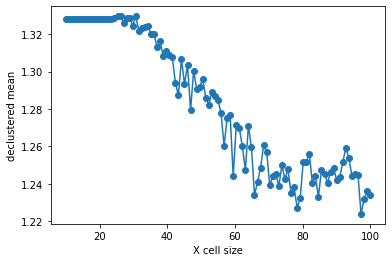

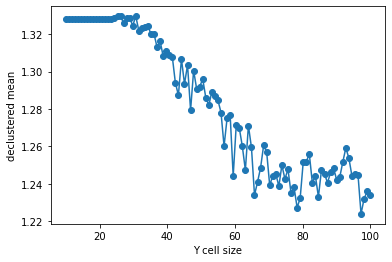

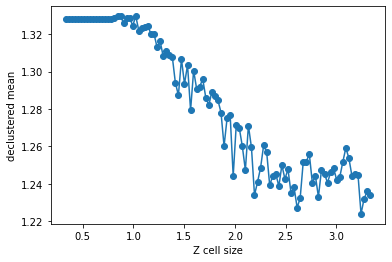

In [17]:
#declustering parameters 
parameters_declus = { 
        'x'      :  mydholes.table['cmp'].loc[:, 'xm'], 
        'y'      :  mydholes.table['cmp'].loc[:, 'ym'],  
        'z'      :  mydholes.table['cmp'].loc[:, 'zm'], 
        'vr'     :  mydholes.table['cmp'].loc[:, 'Au'],   
        'anisy'  :  1.,       
        'anisz'  :  1/30,     # the shorter nominal spacing between drillholes is 30 1/30 is 1m in isotropic distance    
        'minmax' :  0,                 
        'ncell'  :  100,                  
        'cmin'   :  10., 
        'cmax'   :  100.,                 
        'noff'   :  8,                    
        'maxcel' :  -1}               

# declustering 
wtopt,vrop,wtmin,wtmax,error, \
xinc,yinc,zinc,rxcs,rycs,rzcs,rvrcr = pygslib.gslib.declus(parameters_declus)

#Plotting declustering optimization results
plt.plot (rxcs, rvrcr, '-o')
plt.xlabel('X cell size')
plt.ylabel('declustered mean')
plt.show()
plt.plot (rycs, rvrcr, '-o')
plt.xlabel('Y cell size')
plt.ylabel('declustered mean')
plt.show()
plt.plot (rzcs, rvrcr, '-o')
plt.xlabel('Z cell size')
plt.ylabel('declustered mean')
plt.show()

Now we fix the cell size to 60 x 60 x 1 

In [18]:
#declustering parameters 
parameters_declus['ncell'] = 1
parameters_declus['cmin'] = 60.
parameters_declus['cmax'] = 60.
parameters_declus['anisz'] = 1/60.
# declustering 
wtopt,vrop,wtmin,wtmax,error, \
xinc,yinc,zinc,rxcs,rycs,rzcs,rvrcr = pygslib.gslib.declus(parameters_declus)

# Adding declustering weight to a drillhole interval table
mydholes.table['cmp']['declustwt'] = 1
mydholes.table['cmp'].loc[:, 'declustwt'] = wtopt

# calculating declustered mean
decl_mean = rvrcr[0]

print ('declustered mean:', decl_mean)

declustered mean: 1.3074799124567966


In [19]:
mydholes.table['cmp']['Au'].mean()

1.3279108768783785

#### Variography

For now use this variogram model

In Pygslib: 
```
vario_model = {
            # Variogram parameters Pygslib
            # ----------
            'c0'         : 0.1,   
            'it'         : [1],    # 
            'cc'         : [.9],     
            'aa'         : [100],   
            'aa1'        : [100],  
            'aa2'        : [20],   
            'ang1'       : [0],   
            'ang2'       : [0],  
            'ang3'       : [-15]}  

```


In gslib: 

```
1    0.1                      -nst, nugget effect
1    0.9  0.0   0.0  -15.0     -it,cc,ang1,ang2,ang3
       100.0  100.0  20.0     -a_hmax, a_hmin, a_vert


nst and c0: the number of variogram structures and the nugget
it:  the type of structure
cc:  the c parameter "sill"
ang1,ang2,ang3: the angles defining the geometric anisotropy
aa: also aa_hmax, the maximum horizontal range
aa1: also aa_hmin, the minimum horizontal range
aa2: also aa_vert, the vertical range


it is 

1. Spherical (use actual range)
2. Exponential (use practical range)
3. Gaussian (use practical range)
4. Power law variogram
5. Cosine hole effect model


```

### Interpolation and validation

In [20]:
# Creating BHID of type integer, this is to be able to use drillhole id in Fortran!
# The old GSLIB KT3D was modified in PyGSLIB to restrict a minimum number of samples per drillholes. 
# The drillhole ID has to be an integer greater than zero.  
# The function below generates the field `BHIDint` (the integer ID) for you.
mydholes.txt2intID('cmp')

In [21]:
mydholes.table['cmp'][['BHID',  'BHIDint', 'FROM', 'TO']]

,BHID,BHIDint,FROM,TO
0,0,1,53.0,54.0
1,0,1,54.0,55.0
2,0,1,55.0,56.0
3,0,1,56.0,57.0
4,0,1,57.0,58.0
...,...,...,...,...
365,9,29,40.0,41.0
366,9,29,41.0,42.0
367,9,29,42.0,43.0
368,9,29,43.0,44.0


The parameters for interpolation are passed as a python dictionary ({}). Some of the parameters are optional. 
You can get the list of parameters and a sample/template dictionary with the command 
`pygslib.gslib.kt3d.__doc__`

In [22]:
print(pygslib.gslib.kt3d.__doc__)

Estimates with the GSLIB program KT3D

    This is a wrap for the GSLIB Fortran code of the program KT3D Version 2.0,
    originally in Fortran 77. Only minor changes were included, the most
    relevant are:

     - support for maximum number of samples per drillhole was
       implemented
     - the direct file output was redirected to numpy arrays
     - the input (for grid estimate) is now as numpy arrays.
       The grid definition was retained because is an input
       of the GSLIB search super-block algorithm.
     - the trimming limits were removed; you may filter out
       undesired values before estimating

    Parameters
    ----------
        parameters  :  dict
            dictionary with calculation parameters


    The dictionary with parameters may be as follows::


        kt3d_parameters = {
            # Input Data
            # ----------
            'x' : ,   # 1D array('f'), x coordinates of input data
            'y' : ,   # 1D array('f'), y coordinates of inpu

In [23]:
# get a test block with IJK 16541
XC = mymodel.bmtable.loc[mymodel.bmtable['IJK']==16541, 'XC'].values
YC = mymodel.bmtable.loc[mymodel.bmtable['IJK']==16541, 'YC'].values
ZC = mymodel.bmtable.loc[mymodel.bmtable['IJK']==16541, 'ZC'].values
# these are three arrays with block coordinates x, y, z of the block centroid
XC, YC, ZC

(array([87.5]), array([97.5]), array([57.5]))

In [24]:
# creating parameter dictionary for estimation in one block (note also that 'idbg'       : 1 will output the testing data)
kt3d_Parameters = {
            # Input Data (Only using intervals in the mineralized domain)
            # ----------
            'x' : mydholes.table["cmp"]['xm'].values, 
            'y' : mydholes.table["cmp"]['ym'].values,
            'z' : mydholes.table["cmp"]['zm'].values,
            'vr' : mydholes.table["cmp"]['Au'].values,
            'bhidint' : mydholes.table["cmp"]['BHIDint'].values, # an interger BHID
            # Output (Target) 
            # ----------
            'nx' : 100,  # these parameters are only used to define supperblock search
            'ny' : 100,  
            'nz' : 100, 
            'xmn' : 0,  
            'ymn' : 0,  
            'zmn' : 0,  
            'xsiz' : 5,  
            'ysiz' : 5,   
            'zsiz' : 5, 
            'nxdis' : 5,  
            'nydis' : 5,  
            'nzdis' : 3,  
            'outx' : XC,  
            'outy' : YC,
            'outz' : ZC,
            # Search parameters 
            # ----------
            'radius'     : 60,   
            'radius1'    : 60,   
            'radius2'    : 8,   
            'sang1'      : 0,  
            'sang2'      : 0,   
            'sang3'      : -15,   
            'ndmax'      : 20,    
            'ndmin'      : 7,  
            'noct'       : 0,
            'nbhid'      : 5,   
            # Kriging parameters and options 
            # ----------
            'ktype'      : 1,   # 1 Ordinary kriging 
            'idbg'       : 1,   # 0 no debug 
            # Variogram parameters Pygslib
            # ----------
            'c0'         : 0.1,   
            'it'         : [1],    
            'cc'         : [.9],     
            'aa'         : [100],   
            'aa1'        : [100],  
            'aa2'        : [20],   
            'ang1'       : [0],   
            'ang2'       : [0],  
            'ang3'       : [-15]}   

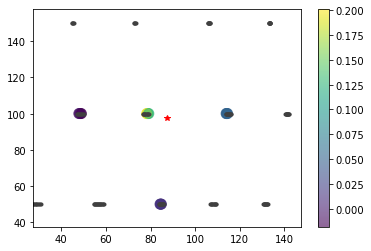

In [25]:
# estimating in one blocks and observe the data selected
estimate, debug, summary = pygslib.gslib.kt3d(kt3d_Parameters)

In [26]:
# save the data to visualize in paraview

# saving debug to a csv file using Pandas. drag and drop in paraview and use table to point 
pd.DataFrame(    {'x':debug['dbgxdat'],
                  'y':debug['dbgydat'],
                  'z':debug['dbgzdat'],
                  'wt':debug['dbgwt']}).to_csv('dbg_data.csv', index=False)

# save the search ellipse to a VTK file
pygslib.vtktools.SavePolydata(debug['ellipsoid'], 'search_ellipsoid')

You can validate the estimate in Paraview. Observe the negative wights (almost equal to zero), but still concerning for an Gold deposit. 
 
 We will ignore these negative weights for now, but you may take actions such as using longer composites, increasing the nugget, and reducing the number of samples per drillhole (`'nbhid'`).  
 
 <img src ='fig2.JPG' >
 <figcaption>Fig.2 - Validation of the estimate in one block.</figcaption>
 
 Now we are ready to run the estimate in the entire model. 

In [27]:
# set the debug to zero:
kt3d_Parameters['idbg'] = 0 

# set the coordinates array ecual to all blocks in the domain 
kt3d_Parameters['outx'] =  mymodel.bmtable['XC'].values  
kt3d_Parameters['outy'] =  mymodel.bmtable['YC'].values  
kt3d_Parameters['outz'] =  mymodel.bmtable['ZC'].values  

# estimating in all blocks
estimate, debug, summary = pygslib.gslib.kt3d(kt3d_Parameters)

In [28]:
# adding the estimate into the model
mymodel.bmtable['Au_OK'] = estimate['outest']       # The estimator defined in the parameter dic
mymodel.bmtable['Au_ID2'] = estimate['outidpower']  # The inverse of the distance to the power defined on 'id2power' (default 2)
mymodel.bmtable['Au_NN'] = estimate['outnn']        # The nearest neighbour estimate
mymodel.bmtable['Au_Lagrange'] = estimate['outlagrange']   # lagrange multiplier (if using ordinary kriging)
mymodel.bmtable['Au_KVar']= estimate['outkvar']            # Kriging variance 

In [29]:
# exporting block model to VTK (unstructured grid) 
mymodel.blocks2vtkUnstructuredGrid(path='bmodel.vtu')

# exporting block model to csv
# the model table is a pandas DataFrame, use the function to_csv
mymodel.bmtable.to_csv('bmodel.csv', index = False)

### Validating results

Basic validations are:

 - visual validation
 - comparison of mean grades
 - swath plots 
 - global change of support (GCOS)


#### Visual validations 

Use Paraview :)

#### Mean comparison

In [30]:
print ("Mean in model OK   :",  mymodel.bmtable['Au_OK'].mean())
print ("Mean in model ID2   :",  mymodel.bmtable['Au_ID2'].mean())
print ("Mean in model NN   :",  mymodel.bmtable['Au_NN'].mean())    # NN is equivalent to a declustered mean 
print ("Mean in data    :", mydholes.table["cmp"]['Au'].mean())
print ("Declustered mean:", decl_mean)

Mean in model OK   : 1.1692686
Mean in model ID2   : 1.3287781
Mean in model NN   : 1.1181831
Mean in data    : 1.3279108768783785
Declustered mean: 1.3074799124567966


#### Swath plots

We use the NN as declustered mean and the pandas DataFrame function `groupbay` to create the slices of the model in the X, Y and Z directions.

<AxesSubplot:xlabel='XC'>

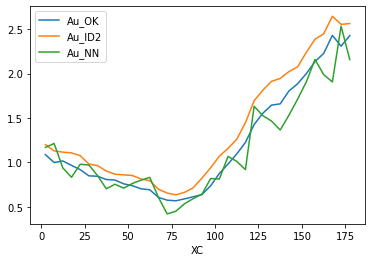

In [31]:
mymodel.bmtable.groupby('XC')[['Au_OK','Au_ID2','Au_NN']].mean().plot()

<AxesSubplot:xlabel='YC'>

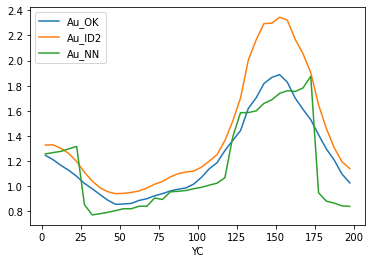

In [32]:
mymodel.bmtable.groupby('YC')[['Au_OK','Au_ID2','Au_NN']].mean().plot()

<AxesSubplot:xlabel='ZC'>

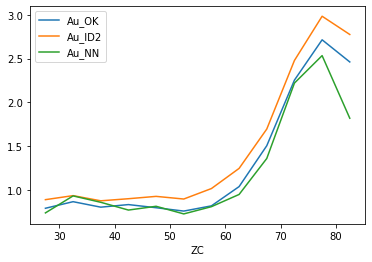

In [33]:
mymodel.bmtable.groupby('ZC')[['Au_OK','Au_ID2','Au_NN']].mean().plot()

#### Global change of support  

('Raw Variance', 2.2468695806900487)
('Variance from PCI', 2.233368105787908)
('zamin', 0.040193994605426664)
('zamax', 9.453352695948624)
('yamin', -2.6095219043808764)
('yamax', 2.6915383076615322)
('zpmin', 0.036812858513089)
('zpmax', 9.557591339287837)
('ypmin', -2.9355871174234847)
('ypmax', 2.929585917183437)


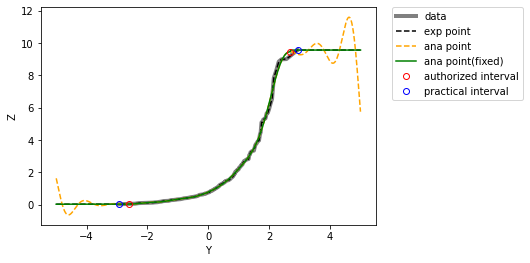

In [34]:
# Fit anamorphosis by changing, zmax, zmin, and extrapolation function
PCI, H, raw, zana, gauss, Z , P, raw_var , PCI_var, fig, zamin, zamax, yamin, yamax, zpmin, zpmax, ypmin, ypmax  = pygslib.nonlinear.anamor(
                         z = mydholes.table["cmp"]['Au'], 
                         w = mydholes.table["cmp"]['declustwt'], 
                         zmin = mydholes.table["cmp"]['Au'].min(), 
                         zmax = mydholes.table["cmp"]['Au'].max(),
                         zpmin = None, zpmax = None,
                         ymin=-5, ymax=5,
                         ndisc = 5000,
                         ltail=1, utail=4, ltpar=1, utpar=1.5, K=40)

In [35]:
# calc block covariance
parameters_cov = {
           # Coordinates of the discretization points (using 500 points located at random in the block)
            'xdb'  :  np.random.rand(1000)*5, # array('f')
            'ydb'  :  np.random.rand(1000)*5, # array('f')
            'zdb'  :  np.random.rand(1000)*5, # array('f')
           # Variogram model
            'c0'         : 0.1,   
            'it'         : [1],    
            'cc'         : [.9],     
            'aa'         : [100],   
            'aa1'        : [100],  
            'aa2'        : [20],   
            'ang1'       : [0],   
            'ang2'       : [0],  
            'ang3'       : [-15]} 


cbb = pygslib.gslib.block_covariance(parameters_cov)

# calculate the support correction coefficient r
r = pygslib.nonlinear.get_r(Var_Zv = cbb, PCI = PCI)

print ('cbb :', cbb)
print ('r   :', r)

cbb : 0.7769696103844224
r   : 0.6586304990080434


('zamin blk', 0.036813077126897166)
('zamax blk', 9.557591339287837)
('yamin blk', -4.995999199839968)
('yamax blk', 4.997999599919984)
('zpmin blk', 0.036813072640339034)
('zpmax blk', 9.557591339287837)
('ypmin blk', -5.0)
('ypmax blk', 5.0)


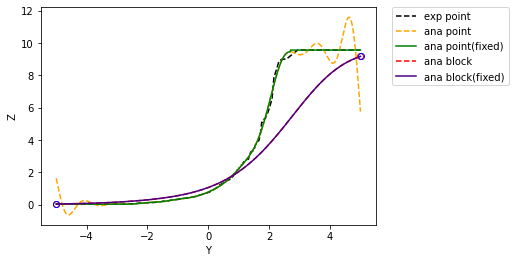

In [36]:
# fit block anamorphosis
ZV, PV, fig2, zamin, zamax_blk, yamin_blk, yamax_blk, zpmin_blk, zpmax_blk, ypmin_blk, ypmax_blk = pygslib.nonlinear.anamor_blk( PCI, H, r = r, gauss = gauss, Z = Z,
                  ltail=1, utail=1, ltpar=1, utpar=1,
                  raw=raw, zana=zana)

In [37]:
# calculate grade tonnage courve

cutoff = np.arange(0, 3, 0.01)
tt = []
gg = []
label = []

# calculate GTC from gaussian in block support 
t,ga,gb = pygslib.nonlinear.gtcurve (cutoff = cutoff, z=ZV, p=PV, varred = 1, ivtyp = 0, zmin = 0, zmax = None,
             ltail = 1, ltpar = 1, middle = 1, mpar = 1, utail = 1, utpar = 1,maxdis = 1000)
tt.append(t)
gg.append(ga)
label.append('DGM with block support')

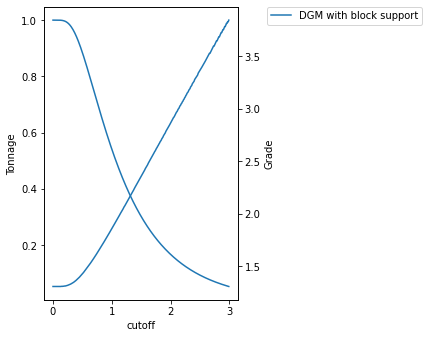

In [38]:
# see how it look with GCOS. This is also know as global estimation
fig = pygslib.nonlinear.plotgt(cutoff = cutoff, t = tt, g = gg, label = label)

Now, we can compare the global resources estimated with the discrete gaussian model with the resources estimated with the block model. 
We can filter blocks to get the grade and tonnage curves at any arbitrary cutoff. However, there is another way. We convert the clock model estimate to a CDF, and then we can generate the grade and tonnage curves using the PyGSLIB function `pygslib.nonlinear.gtcurve`

In [39]:
# get the CDF of the block model estimates

# CDF of the kriging estimate
parameters_probplt = {
        'iwt'  : 0,                             #int, 1 use declustering weight
        'va'   : mymodel.bmtable['Au_OK'][mymodel.bmtable['Au_OK'].notnull()].values,             # array('d') with bounds (nd)
        'wt'   : np.ones(mymodel.bmtable['Au_OK'][mymodel.bmtable['Au_OK'].notnull()].shape[0])} # array('d') with bounds (nd), wight variable (obtained with declust?)


binval_ok,cl_ok,xpt025,xlqt,xmed,xuqt,xpt975,xmin,xmax, \
xcvr,xmen,xvar,error = pygslib.gslib.__plot.probplt(**parameters_probplt)

# CDF of the inverse of the distance estimate 
parameters_probplt = {
        'iwt'  : 0,                             #int, 1 use declustering weight
        'va'   : mymodel.bmtable['Au_ID2'][mymodel.bmtable['Au_OK'].notnull()].values,             # array('d') with bounds (nd)
        'wt'   : np.ones(mymodel.bmtable['Au_OK'][mymodel.bmtable['Au_OK'].notnull()].shape[0])} # array('d') with bounds (nd), wight variable (obtained with declust?)

binval_id2,cl_id2,xpt025,xlqt,xmed,xuqt,xpt975,xmin,xmax, \
xcvr,xmen,xvar,error = pygslib.gslib.__plot.probplt(**parameters_probplt)

In [40]:
# Grade and tonnage curves from CDF of the block model estimates

# calculate GTC ok 
t,ga,gb = pygslib.nonlinear.gtcurve (cutoff = cutoff, z=cl_ok, p=binval_ok, varred = 1, ivtyp = 2, zmin = 0, zmax = None,
             ltail = 1, ltpar = 1, middle = 1, mpar = 1, utail = 1, utpar = 1,maxdis = 1000)
tt.append(t)
gg.append(ga)
label.append('Ordinary Kriging')

# calculate GTC in block support
t,ga,gb = pygslib.nonlinear.gtcurve (cutoff = cutoff, z=cl_id2, p=binval_id2, varred = 1, ivtyp = 2, zmin = 0, zmax = None,
             ltail = 1, ltpar = 1, middle = 1, mpar = 1, utail = 1, utpar = 1,maxdis = 1000)
tt.append(t)
gg.append(ga)
label.append('Inverse of the Distance 2')

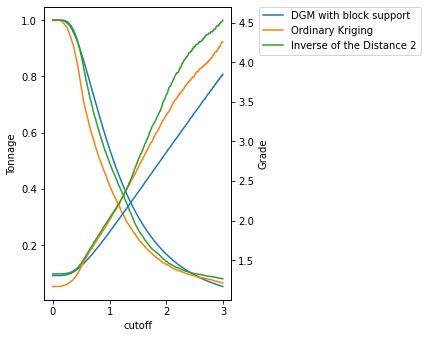

In [41]:
fig = pygslib.nonlinear.plotgt(cutoff = cutoff, t = tt, g = gg, label = label)

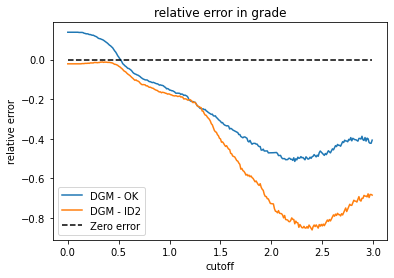

In [42]:
# we can plot diferences (relative error in grade)
plt.plot (cutoff, gg[0]-gg[1], label = 'DGM - OK')
plt.plot (cutoff, gg[0]-gg[2], label = 'DGM - ID2')
plt.plot (cutoff, np.zeros(cutoff.shape[0]),'--k', label = 'Zero error')
plt.title('relative error in grade')
plt.xlabel ('cutoff')
plt.ylabel ('relative error')
plt.legend()

Text(0.5, 1.0, 'relative error in tonnage')

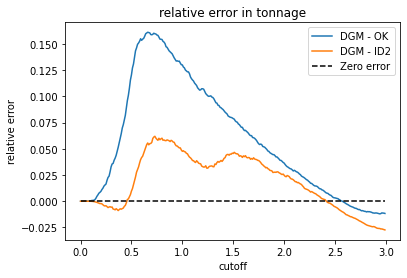

In [43]:
# we can plot diferences (relative error in tonnage)
plt.plot (cutoff, tt[0]-tt[1], label = 'DGM - OK')
plt.plot (cutoff, tt[0]-tt[2], label = 'DGM - ID2')
plt.plot (cutoff, np.zeros(cutoff.shape[0]),'--k', label = 'Zero error')
plt.legend()
plt.xlabel ('cutoff')
plt.ylabel ('relative error')
plt.title('relative error in tonnage')

Let's save the global change of support validation results as a CSV

In [44]:
GCOS_validation = pd.DataFrame({'cutoff': cutoff,
                               'Tons DGM' : tt[0],
                               'Tons OK'  : tt[1],
                               'Tons ID2' : tt[2],
                               'Au DGM (g/t)' : gg[0],
                               'Au OK (g/t)'  : gg[1],
                               'Au ID2 (g/t)' : gg[2],})

GCOS_validation.to_csv('GCOS validation.csv', index = False)

GCOS_validation

,cutoff,Tons DGM,Tons OK,Tons ID2,Au DGM (g/t),Au OK (g/t),Au ID2 (g/t)
0,0.00,1.000000,1.000000,1.000000,1.307262,1.169356,1.328789
1,0.01,1.000000,0.999988,0.999995,1.307262,1.169356,1.328789
2,0.02,1.000000,0.999976,0.999990,1.307262,1.169356,1.328789
3,0.03,1.000000,0.999964,0.999985,1.307262,1.169356,1.328789
4,0.04,1.000000,0.999952,0.999980,1.307262,1.169356,1.328789
...,...,...,...,...,...,...,...
295,2.95,0.056427,0.068188,0.082860,3.815540,4.215492,4.493357
296,2.96,0.055791,0.066895,0.082172,3.815540,4.234312,4.512136
297,2.97,0.055162,0.066458,0.081866,3.831014,4.253470,4.512136
298,2.98,0.054540,0.065873,0.081607,3.831014,4.253470,4.512136
